## This note is used to show training in RFDiffusion


In [3]:
# sample a structure from PDB
import requests
import os

def fetch_pdb(pdb_id, save_dir="pdb_files"):
    """
    Fetches a PDB file from the RCSB Protein Data Bank and saves it locally.
    
    Args:
        pdb_id (str): The PDB ID of the structure to fetch (e.g., "1HHO").
        save_dir (str): Directory to save the PDB file. Default is 'pdb_files'.
        
    Returns:
        str: Path to the saved PDB file, or None if download failed.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Construct the URL for the PDB file
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    save_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    
    try:
        # Download the PDB file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        # Write the file to the save directory
        with open(save_path, "wb") as pdb_file:
            for chunk in response.iter_content(chunk_size=1024):
                pdb_file.write(chunk)
        
        print(f"PDB file {pdb_id} successfully downloaded to {save_path}")
        return save_path
    except requests.exceptions.RequestException as e:
        print(f"Failed to download PDB file {pdb_id}: {e}")
        return None

# Example usage:
pdb_id = "1UBQ"  # Replace with your desired PDB ID
fetch_pdb(pdb_id)


PDB file 1UBQ successfully downloaded to pdb_files/1UBQ.pdb


'pdb_files/1UBQ.pdb'

In [4]:
# convert pdb to numpy 
import numpy as np

import numpy as np
import torch

import numpy as np

def pdb_to_xyz_n_ca_c(pdb_file):
    """
    Extracts and groups N, CA, and C atom coordinates by residue from a PDB file.
    
    Args:
        pdb_file (str): Path to the PDB file.
        
    Returns:
        np.ndarray: Array of shape (num_residues, 3, 3) with coordinates for N, CA, C atoms.
    """
    from collections import defaultdict

    # Map of (chain_id, res_seq) → {'N': [...], 'CA': [...], 'C': [...]}
    residues = defaultdict(dict)

    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_name = line[12:16].strip()
                if atom_name in {"N", "CA", "C"}:
                    chain_id = line[21].strip()
                    res_seq = int(line[22:26].strip())  # Residue index
                    res_key = (chain_id, res_seq)

                    x = float(line[30:38].strip())
                    y = float(line[38:46].strip())
                    z = float(line[46:54].strip())

                    residues[res_key][atom_name] = [x, y, z]

    # Collect residues that have all three atoms
    grouped_coords = []
    for res in sorted(residues.keys()):
        atom_dict = residues[res]
        if all(name in atom_dict for name in ("N", "CA", "C")):
            grouped_coords.append([
                atom_dict["N"],
                atom_dict["CA"],
                atom_dict["C"]
            ])

    return np.array(grouped_coords)  # shape: (num_residues, 3, 3)


# Example usage:
pdb_file_path = 'pdb_files/1UBQ.pdb'  # Replace with the path to your PDB file
arr = pdb_to_xyz_n_ca_c(pdb_file_path)

# Reshaping the array to shape (n, 3, 3)
xyz = torch.tensor(arr)


# Print or save the resulting XYZ array
print("XYZ Array Shape:", xyz.shape)
#print(xyz_array)



XYZ Array Shape: torch.Size([76, 3, 3])


In [5]:
import sys
sys.path.append('/home/yunyao/RFdiffusion/rfdiffusion')

from util import rigid_from_3_points

In [6]:
# extract ca and r0 as ground truth
#xyz = xyz - xyz[:, 1, :].mean(dim=0)
xyz = xyz - xyz[:, 1, :].mean(dim=0)

if torch.is_tensor(xyz):
        xyz = xyz.numpy()
N = torch.from_numpy(xyz[None, :, 0, :])
Ca = torch.from_numpy(xyz[None, :, 1, :])  # [1, num_res, 3, 3]
C = torch.from_numpy(xyz[None, :, 2, :])

# scipy rotation object for true coordinates
R_true, Ca = rigid_from_3_points(N, Ca, C)
R_true = R_true[0]
Ca = Ca[0]

#xyz = xyz - xyz[:, 1, :].mean()  # center the protein to origin
print(R_true.shape, Ca.shape)


torch.Size([76, 3, 3]) torch.Size([76, 3])


In [7]:
from diffusion import IGSO3

T=200
min_sigma=0
max_sigma=1
min_b=0
max_b=1
cache_dir='./cache'

# rotation noise linear schedulear sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)
# sigma_min = 0.02, beta_min =1.06  beta_max=1.77
# rotation noise log schedular  log(sigma(t))= logsigma_min + t/T * (log(sigma_max)-log(sigma_min))

# in the SI, it seems the linear one is used and max_sigma is not used
test = IGSO3(T=T,
        min_sigma=0.02,
        max_sigma=1,
        min_b=1.06,
        max_b=1.77,
        cache_dir=cache_dir,
        num_omega=1000,
        schedule="linear",
        L=2000)

In [8]:
# now visulaization  rotatio noise schedule
print(test.igso3_vals['cdf'].shape)  #(num_sigma,  num_omega)
#test.igso3_vals.keys()
#test.igso3_vals['discrete_sigma'].shape
#test.igso3_vals['discrete_omega'].shape


(500, 1000)


### Alert
Discrete_sigma is different from sigma(t) = sigma_min + (t)*beta_min + 1/2(t)^2(beta_max-beta_min); t ~(0,1) = ts/T  
given ts we get t, and according sigma value based on sigma(t), then we got idx in discrete_sigma for the sigma value  
the idx is finally use to fetch pdf cdf score for according sigma value  

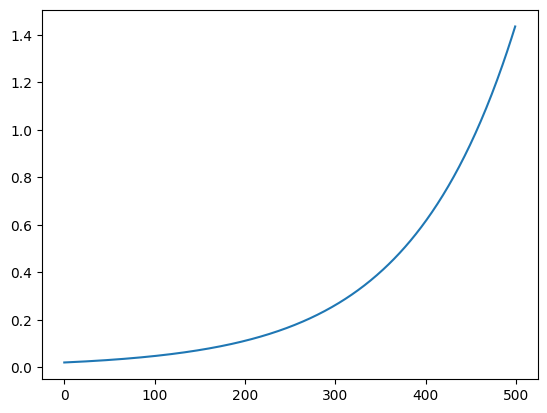

In [ ]:
test.discrete_sigma
import matplotlib.pyplot as plt
plt.plot(test.discrete_sigma)  # this is the sigma used to generate grids to calculate pdf cdf and score



In [10]:
# g(t)= d/dt( sigma(t)^2)
test.g(0.4)

tensor(1.1602)

In [11]:
# import the translation diffuser
from diffusion import EuclideanDiffuser
# translation noise schedular beta(t) = beta_min + (beta_max-beta_min)*t/T
# in the paper beta_max=0.07, beta_min=0.01
trans_test=EuclideanDiffuser(T=T,
        b_0=0.01,
        b_T=0.07,
        schedule_type="linear")

In [12]:
# now perturb the structure one translation one rotation
diffused_T, deltas = trans_test.diffuse_translations(
            torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None
        )
print(diffused_T.shape)
print(deltas.shape) # ca cooridnate difference


torch.Size([76, 200, 3, 3])
torch.Size([76, 200, 3])


In [13]:
diffused_frame_crds, diffused_frames = test.diffuse_frames(
           torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None, t_list=None
        )

In [14]:
print(diffused_frame_crds.shape)

(76, 200, 3, 3)


NCA avg: 1.4733696107286514 std: 0.016948937934009423
CAC  avg: 1.5215819483790822 std: 0.015672407821294372
NCA avg: 1.4733696107286511 std: 0.01694893793400949
CAC  avg: 1.5215819483790824 std: 0.015672407821294265
NCA avg: 1.4733696107286514 std: 0.01694893793400956
CAC  avg: 1.5215819483790822 std: 0.015672407821294306
NCA avg: 1.4733696107286514 std: 0.016948937934009572
CAC  avg: 1.5215819483790822 std: 0.0156724078212941
NCA avg: 1.4733696107286514 std: 0.016948937934009756
CAC  avg: 1.5215819483790824 std: 0.01567240782129421


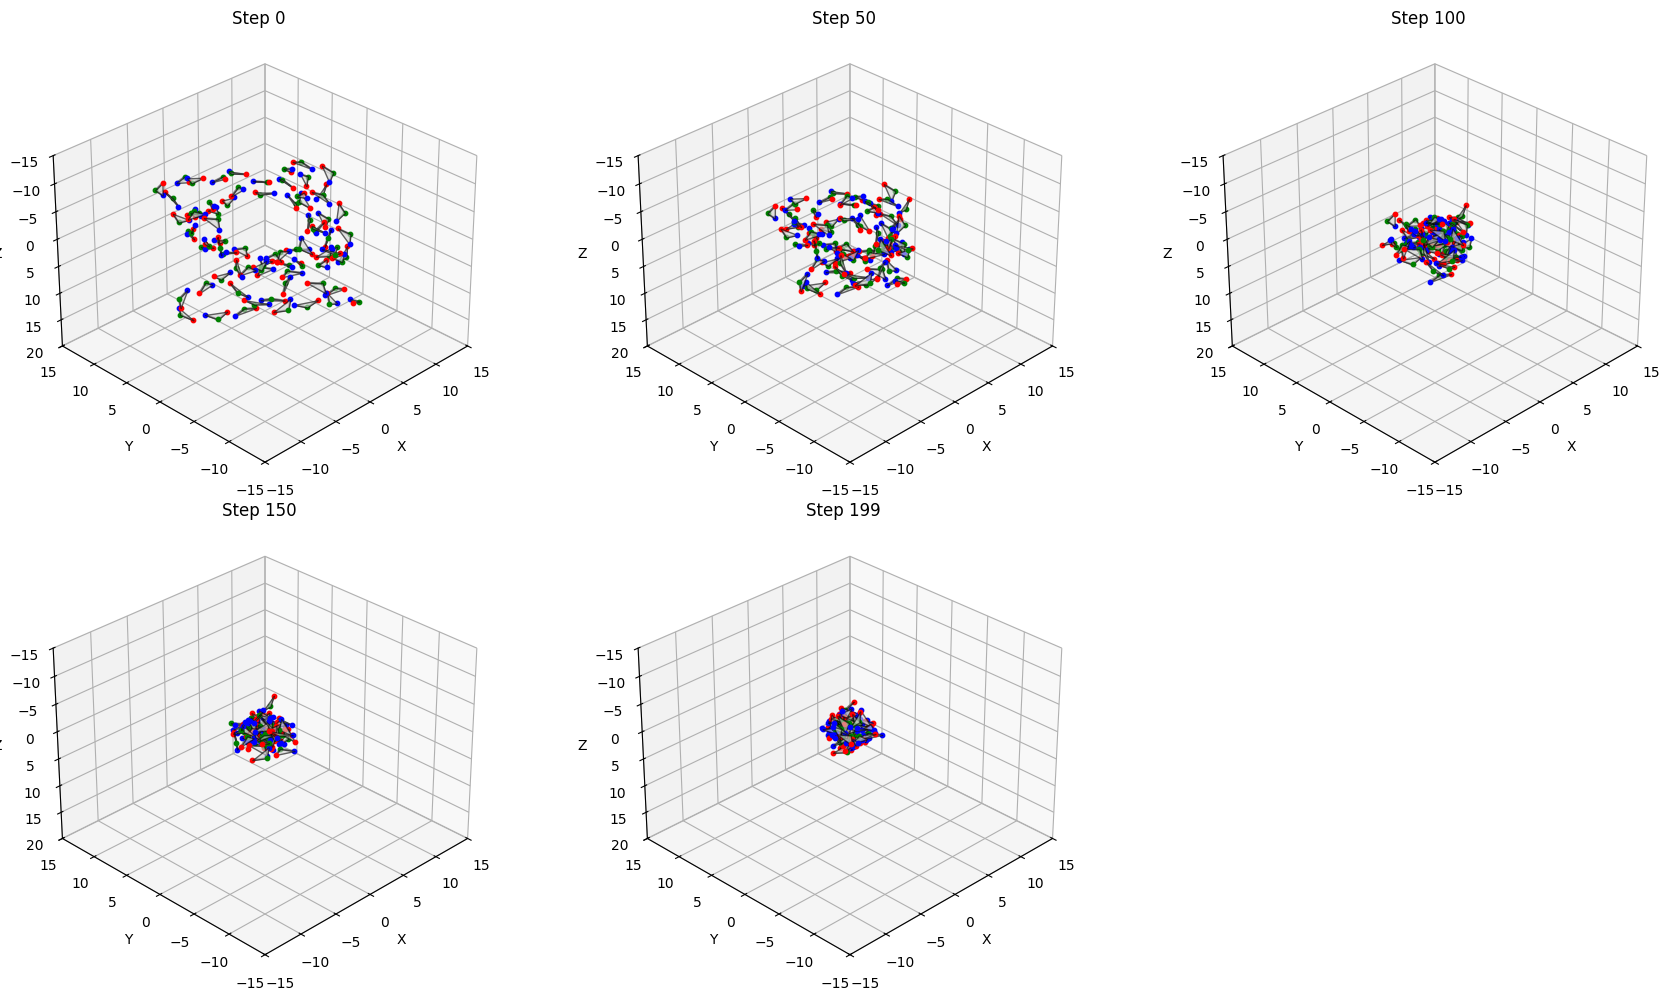

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))



for i, step_index in enumerate(step_indexes):
    coords = diffused_T[:, step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = diffused_T.shape[0]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()



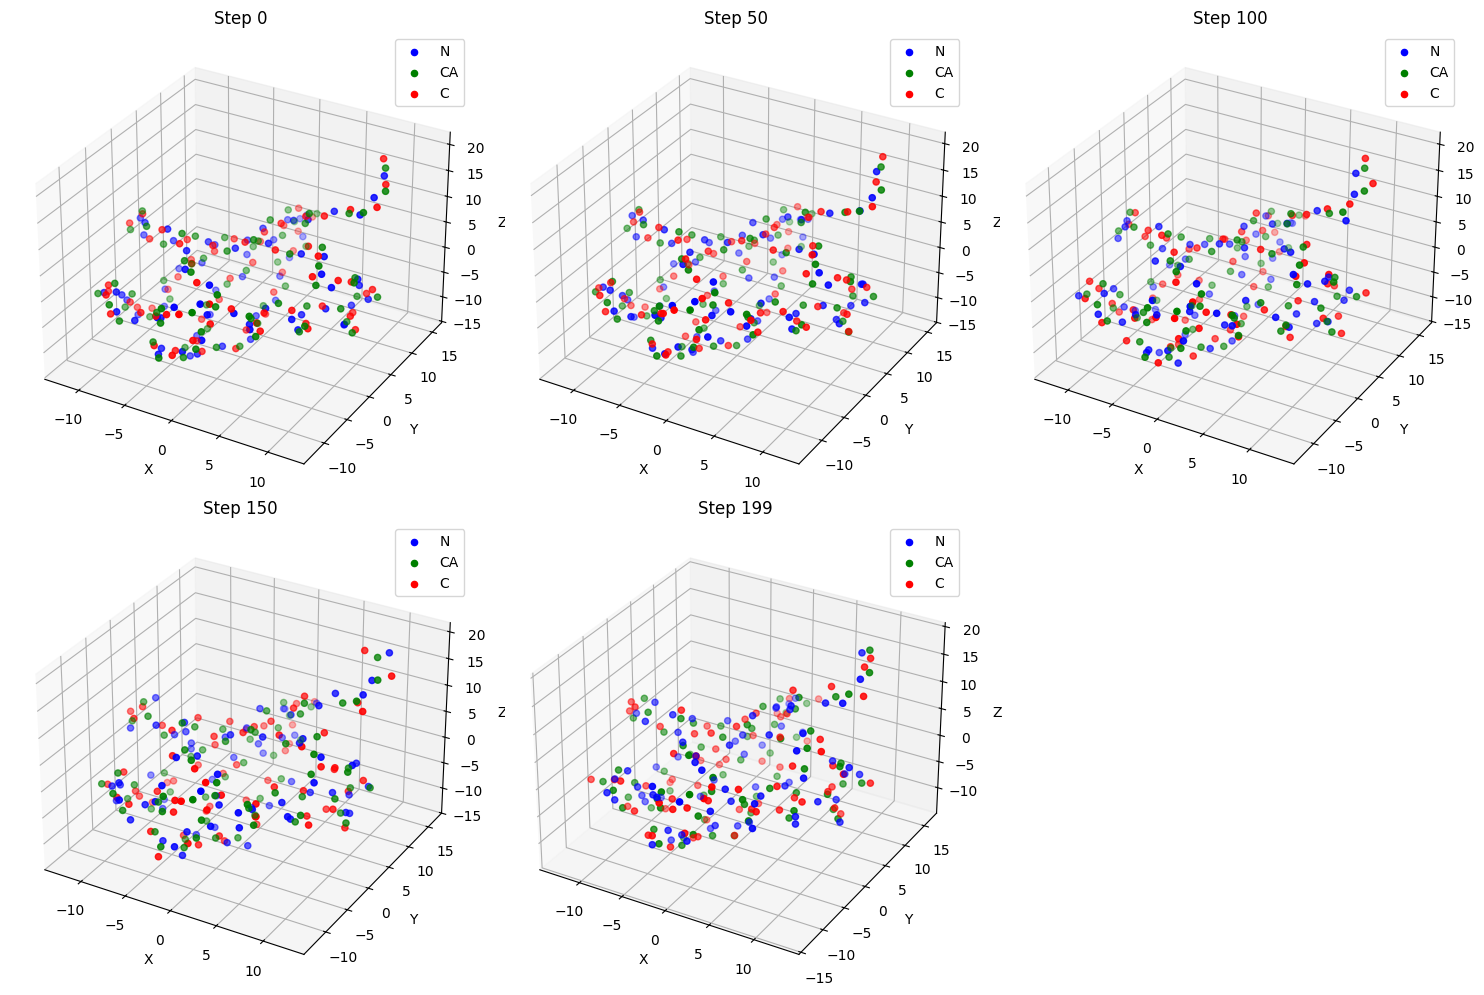

In [16]:
#Now visualize the rotation diffusion
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Set up subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(5 * cols, 5 * rows))

for i, step_index in enumerate(step_indexes):
    coords = diffused_frame_crds[:, step_index, :, :]  # shape: [res_num, 3, 3]
    
    N_coords = coords[:, 0, :]   # N atoms
    CA_coords = coords[:, 1, :]  # CA atoms
    C_coords = coords[:, 2, :]   # C atoms
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    ax.scatter(N_coords[:, 0], N_coords[:, 1], N_coords[:, 2], color='blue', label='N', s=20)
    ax.scatter(CA_coords[:, 0], CA_coords[:, 1], CA_coords[:, 2], color='green', label='CA', s=20)
    ax.scatter(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], color='red', label='C', s=20)
    
    ax.set_title(f"Step {step_index}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

plt.tight_layout()
plt.show()


### Questions

I am quite confused by the translation_diffuser as I thought N, CA, C within the same residue will diffuse togethere. But it is obviously not the case. Based on the code, this shouldn't happen.

### trouble shoot:

It turns out to be the scaling issue of the axis.  After printing out the average NCA CAC bond lengthes, we know that rigid frame among CA N C is perserved. 

After fixing the sacles of axises, it makes sense now.

In [17]:
# Now combine the translation and rotation
# As protein is kinda seen as point cloud, translation and rotaion is independent 
# Due to Wigner nature (diffusion  Wt-Ws = (sigma(t)^2-sigma(s)^2)*e ~N(0, Id)), we could can compute diffused 
#coordinates at any time without simulating adding noise process.


# method 1: used in rfdiffusion 
cum_delta = deltas.cumsum(dim=1) # cum_delta is noise for each step  [L, n, 3] -> [L,n,3]
        # The coordinates of the translated AND rotated frames
diffused_BB = (
    torch.from_numpy(diffused_frame_crds) + cum_delta[:, :, None, :] # [L,n,]
).transpose(0, 1)  # [n,L,3,3]

# method 2: I think it is more computationally efficient
diffused_BB2 = (
    torch.from_numpy(diffused_frame_crds) + diffused_T -xyz[:,None,:,:] # [L,n,]
).transpose(0, 1)  # [n,L,3,3]
        # diffused_BB  = torch.from_numpy(diffused_frame_crds).transpose(0,1)

# They are equally applicable.
is_close = torch.allclose(diffused_BB, diffused_BB2, atol=1e-5, rtol=1e-5)
print("Tensors are almost equal:", is_close)
#print('They are the same!')


Tensors are almost equal: True


NCA avg: 1.4733696107286514 std: 0.016948937934009395
CAC  avg: 1.5215819483790822 std: 0.01567240782129436


NCA avg: 1.4733696107286516 std: 0.01694893793400935
CAC  avg: 1.5215819483790824 std: 0.01567240782129436
NCA avg: 1.4733696107286516 std: 0.016948937934009378
CAC  avg: 1.5215819483790822 std: 0.01567240782129439
NCA avg: 1.4733696107286516 std: 0.01694893793400942
CAC  avg: 1.5215819483790822 std: 0.015672407821294383
NCA avg: 1.4733696107286511 std: 0.01694893793400946
CAC  avg: 1.5215819483790822 std: 0.01567240782129441


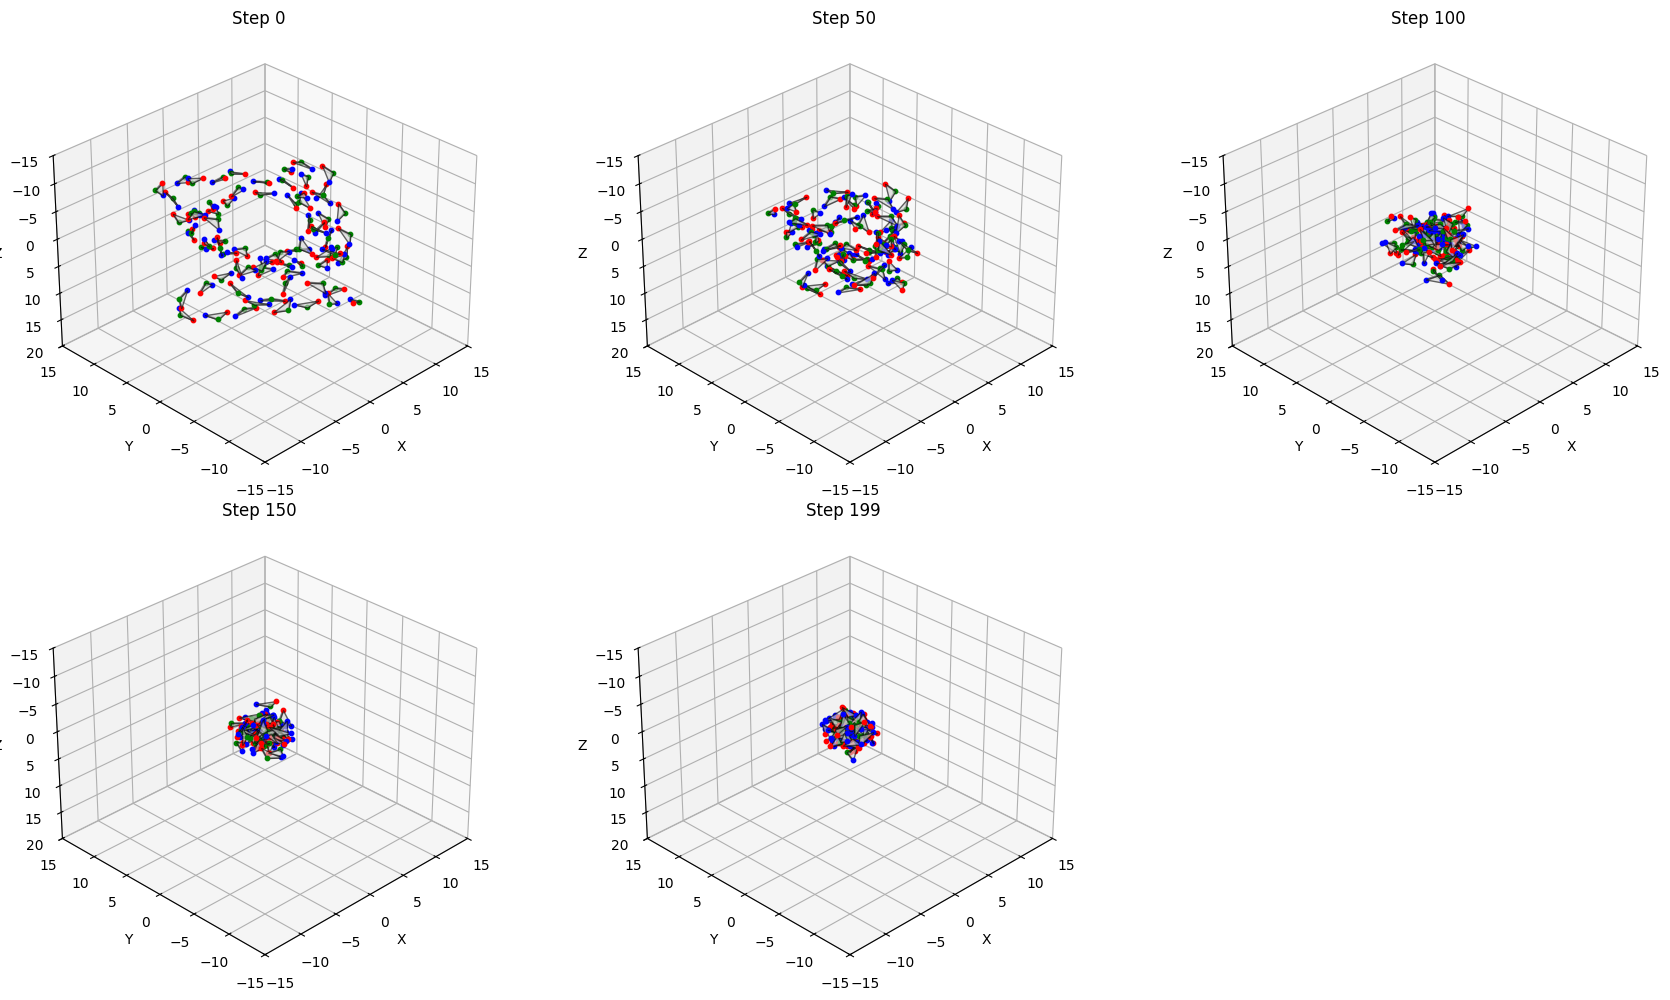

In [18]:
# visualize the final diffused protein with both rotation and translation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))



for i, step_index in enumerate(step_indexes):
    coords = diffused_BB.transpose(0,1)[:, step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = diffused_BB.shape[1]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [23]:
trans_test.beta_schedule.shape
test.discrete_sigma.shape


(500,)

# Step II. the reverse SDE

we know the noise scheduler:

translation: trans_test.bete_schedule, trans_test.alpha_schedule, tran_test.alphabar_shedeule  # [200,]
rotation: test.sigma(t) t ~range(0,200,200)/200 


for the translation diffusion  p(xt-1|xt)= 


for the rotation diffusion part, reserve SDE is used:



In [ ]:

from abc import ABC, abstractmethod
from typing import Optional
import math

class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [ ]:
#from x_t we need know ts 
# based on ts, we know beta_t, alpha_bar_t, aplpha_bat_t_minus_1 (translation)
# also rotaion, sigma2_t, sigma2_t_minus_1 and rotation_score_appromxiation

for ts in 

x_t = diffused_BB[ts]
beta_t = trans_test.beta[ts]
alpha_bar_t = trans_test.alphabar_schedule(ts)
alpha_bar_t_minus_1 = trans_test.alphabar_schedule(ts -1)

# the reverse step on SO3 has been code in reverse_sample_vectorized 
#reverse_sample_vectorized( self, R_t, R_0, t, noise_level, mask=None, return_perturb=False)

def reverse_step(x_t, x0_hat, beta_t, alpha_bar_t, alpha_bar_t_minus_1):
    """
    One reverse diffusion step for all residues.

    Args:
        x_t: tuple (r_t, z_t) at timestep t
        x0_hat: tuple (r0_hat, z0_hat) predicted x^(0)
        beta_t, alpha_bar_t, alpha_bar_t_minus_1, sigma2_t, sigma2_t_minus_1: scalars
        rotation_score_approximation: function (r_t, r0_hat, sigma2_t) -> s_l

    Returns:
        x_{t-1} = (r_{t-1}, z_{t-1})
    """
    r_t, z_t = x_t              # [L, 3, 3], [L, 3]
    r0_hat, z0_hat = x0_hat     # [L, 3, 3], [L, 3]
    L = z_t.shape[0]

    # ---- Update Translations ----
    coeff1 = (alpha_bar_t_minus_1**0.5 * beta_t) / (1 - alpha_bar_t)
    coeff2 = (alpha_bar_t**0.5 * (1 - alpha_bar_t_minus_1)) / (1 - alpha_bar_t)

    mean_z = coeff1 * z0_hat + coeff2 * z_t
    std_z = (beta_t**0.5) * torch.ones_like(z_t)

    z_t_minus_1 = mean_z + std_z * torch.randn_like(z_t)

    # ---- Update Rotations ----
    r_t_minus_1=test.reverse_sample_vectorized(r_t, r0_hat, ts, noise_level=0.5)

    return r_t_minus_1, z_t_minus_1




SyntaxError: invalid syntax (1285157280.py, line 55)

In [ ]:
''' 
  epsilons = torch.randn((L, 3))  # [L, 3], ~ N(0, 1)

    # Assuming f_d = skew-symmetric basis matrices for SO(3)
    f = torch.stack([
        torch.tensor([[0, 0, 0], [0, 0, -1], [0, 1, 0]], dtype=torch.float32),
        torch.tensor([[0, 0, 1], [0, 0, 0], [-1, 0, 0]], dtype=torch.float32),
        torch.tensor([[0, -1, 0], [1, 0, 0], [0, 0, 0]], dtype=torch.float32)
    ])  # [3, 3, 3]

    # Weighted sum: ε_l,d * f_d
    noise_rot = torch.einsum('ld,dij->lij', epsilons, f)  # [L, 3, 3]

    delta_sigma2 = sigma2_t - sigma2_t_minus_1
    noise_term = torch.sqrt(torch.tensor(delta_sigma2)) * noise_rot

    log_rot = (sigma2_t - sigma2_t_minus_1) * torch.einsum('lij,ljk->lik', r_t.transpose(-1, -2), s) + noise_term

    # Matrix exponential of skew-symmetric matrix: use torch.matrix_exp
    exp_log_rot = torch.matrix_exp(log_rot)  # [L, 3, 3]
    r_t_minus_1 = torch.einsum('lij,ljk->lik', r_t, exp_log_rot)  # [L, 3, 3]
    '''